In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform, cosine
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import preprocessing
from itertools import product
import operator
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.mllib.recommendation import ALS

In [2]:
spark = SparkSession.builder.master('local[4]').getOrCreate()

In [3]:
ratings_df = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/data/wa_ratings_data.csv')
ratings_df = ratings_df.rename(columns={'Unnamed: 0':'Username'})
ratings_df = ratings_df.set_index('Username')
ratings_df.drop('Unnamed: 1', axis=1, inplace=True)
ind = []
for index in ratings_df.index:
    if ratings_df.loc[index, :].isnull().all() == True:
        ind.append(index)
ratings_df.drop(ind, inplace=True)
ratings_df.fillna(0, inplace=True)

In [4]:
board_game_index = np.load('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/board_game_dict.npy').item()
board_games = dict((y,x) for x,y in board_game_index.iteritems())
user_index = np.load('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/wa_user_dict.npy').item()
users = dict((y,x) for x,y in user_index.iteritems())
als_data = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/als_ready_wa_ratings_data.csv')
als_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
als_spark_df = spark.createDataFrame(als_data)
als_spark_df.cache()
als_model = ALS(
    itemCol='board_game',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=100,
    maxIter=10
    )
als_fit_model = als_model.fit(als_spark_df)

TypeError: object() takes no parameters

In [15]:
just_ranking_info = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/data/just_ranking_info.csv')
just_ranking_info = just_ranking_info.set_index('Title')
predictions_array = list(product(als_data.loc[:, 'user'].unique(), just_ranking_info.index))
predictions_df = pd.DataFrame(predictions_array, columns=['user', 'board_game'])
spark_pre_predictions_df = spark.createDataFrame(predictions_df)
spark_predictions_df = als_fit_model.transform(spark_pre_predictions_df)
pred_ratings_df = spark_predictions_df.toPandas()
pred_ratings_df.fillna(0, inplace=True)
pred_ratings_df.to_csv('pred_ratings_df.csv')

KeyboardInterrupt: 

In [ ]:
bg_data_with_dummies = pd.read_csv('model_ready_bg_data.csv')
bg_data_with_dummies = bg_data_with_dummies.set_index('Title')
bg_data_with_dummies_als = bg_data_with_dummies.rename(index=board_game_index)
x = bg_data_with_dummies_als.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_als_df = pd.DataFrame(x_scaled, 
                                 index=bg_data_with_dummies_als.index, 
                                 columns=bg_data_with_dummies_als.columns)

for game in normalized_als_df.index:
    if game not in just_ranking_info.index:
        normalized_als_df.drop(game, inplace=True)
        
Y = pdist(normalized_als_df, 'cosine')
Y = squareform(Y)
bg_data_sim = pd.DataFrame(Y, index=normalized_als_df.index, columns=normalized_als_df.index)
bg_data_sim.to_csv('game_similarity_matrix.csv')

In [6]:
preds_train_data = als_fit_model.transform(als_spark_df)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(preds_train_data)
print("Root-mean-square error, rank=100, maxIter=10 = " + str(rmse))

In [ ]:
predictions_df = predictions_data.toPandas()

In [5]:
from scipy.spatial.distance import cosine
import operator

In [16]:
new_user = pd.DataFrame({'new_user': {'Wiz-War':10, 'Terra Mystica':10, 'Twilight Imperium':10}}, index=ratings_df.columns).T
new_user.fillna(0, inplace=True)

In [ ]:
cos_sim_dict = {}
for ind in ratings_df.index:
    cos_sim_dict[ind] = cosine(ratings_df.loc[ind, :], new_user)
sorted_dict = sorted(cos_sim_dict.items(), key=operator.itemgetter(1))
top_3 = sorted_dict[:3]
top_3_keys = [user_index[top_3[i][0]] for i in xrange(len(top_3))]
user_input_df = []
for user in top_3_keys:
    user_df = pd.DataFrame(list(product([user], als_data['board_game'].unique())))
    user_df = user_df.rename(columns={0:'user', 1:'board_game'})
    user_input_df.append(spark.createDataFrame(user_df))
print top_3_keys
pred_array = np.zeros((1, len(als_data['board_game'].unique())))
for user in user_input_df:
    preds = als_fit_model.transform(user).toPandas()
    preds.sort_values('board_game', inplace=True)
    pred_array += preds['prediction'].values
top_3_games = pred_array[0].argsort()[-10:]
print top_3_games
print sorted(pred_array[0])[-10:]
games = []
for ind in top_3_games:
    games.append(board_games[ind])
new_game1 = games[0]
new_game2 = games[1]
new_game3 = games[2]
new_game4 = games[3]
new_game5 = games[4]
new_game6 = games[5]
new_game7 = games[6]
new_game8 = games[7]
new_game9 = games[8]
new_game10 = games[9]
print new_game1
print new_game2
print new_game3
print new_game4
print new_game5
print new_game6
print new_game7
print new_game8
print new_game9
print new_game10

In [9]:
# als_fit_model.save('als_model2')
als_model = ALSModel.load('als_model2/')

In [ ]:
cos_sim_dict = {}
for ind in ratings_df.index:
    cos_sim_dict[ind] = cosine(ratings_df.loc[ind, :], new_user)
sorted_dict = sorted(cos_sim_dict.items(), key=operator.itemgetter(1))
top_3 = sorted_dict[:3]
top_3_keys = [user_index[top_3[i][0]] for i in xrange(len(top_3))]
user_input_df = []
for user in top_3_keys:
    user_df = pd.DataFrame(list(product([user], als_data['board_game'].unique())))
    user_df = user_df.rename(columns={0:'user', 1:'board_game'})
    user_input_df.append(spark.createDataFrame(user_df))
print top_3_keys
pred_array = np.zeros((1, len(als_data['board_game'].unique())))
for user in user_input_df:
    preds = als_model.transform(user).toPandas()
    preds.sort_values('board_game', inplace=True)
    pred_array += preds['prediction'].values
top_3_games = pred_array[0].argsort()[-10:]
print top_3_games
print sorted(pred_array[0])[-10:]
games = []
for ind in top_3_games:
    games.append(board_games[ind])
new_game1 = games[0]
new_game2 = games[1]
new_game3 = games[2]
new_game4 = games[3]
new_game5 = games[4]
new_game6 = games[5]
new_game7 = games[6]
new_game8 = games[7]
new_game9 = games[8]
new_game10 = games[9]
print new_game1
print new_game2
print new_game3
print new_game4
print new_game5
print new_game6
print new_game7
print new_game8
print new_game9
print new_game10

In [ ]:
pred_array.shape

In [11]:
just_ranking_info

,Title,Geek Rating,Avg Rating,Num Ratings
0,12707,8.469,8.66,15951
1,18208,8.306,8.77,6279
2,18969,8.226,8.36,26424
3,17052,8.153,8.29,22791
4,16126,8.130,8.56,7286
5,14862,8.082,8.35,12711
6,287,8.029,8.20,18324
7,3604,8.022,8.19,16163
8,17261,7.994,8.11,24014
9,13567,7.991,8.10,47075


In [12]:
just_ranking_info = pd.read_csv('new_game_ratings.csv')

In [9]:
ratings_df[ratings_df['Gloomhaven']!=0]['Gloomhaven'].mean()

9.464285714285714

In [13]:
just_ranking_info

,Title,Avg Rating,Num Ratings
0,Pandemic Legacy: Season 1,8.66,16218.0
1,Through the Ages: A New Story of Civilization,8.77,6397.0
2,Twilight Struggle,8.36,26547.0
3,Terra Mystica,8.29,22957.0
4,Star Wars: Rebellion,8.56,7433.0
5,Scythe,8.35,13146.0
6,7 Wonders Duel,8.20,18674.0
7,Caverna: The Cave Farmers,8.19,16291.0
8,The Castles of Burgundy,8.11,24188.0
9,Puerto Rico,8.10,47225.0


In [58]:
bg_ranking_data

,Title,Geek Rating,Avg Rating,Num Ratings
0,Pandemic Legacy: Season 1,8.469,8.66,15951
1,Through the Ages: A New Story of Civilization,8.306,8.77,6279
2,Twilight Struggle,8.226,8.36,26424
3,Terra Mystica,8.153,8.29,22791
4,Star Wars: Rebellion,8.130,8.56,7286
5,Scythe,8.082,8.35,12711
6,7 Wonders Duel,8.029,8.20,18324
7,Caverna: The Cave Farmers,8.022,8.19,16163
8,The Castles of Burgundy,7.994,8.11,24014
9,Puerto Rico,7.991,8.10,47075


In [ ]:
games_in_both_dfs = []
for game in ratings_df.columns:
    if game in just_ranking_info.index:
        games_in_both_dfs.append(game)

In [ ]:
just_ranking_info.info()

In [ ]:
just_ranking_info.drop_duplicates(subset=['Title'], keep='first', inplace=True)

In [ ]:
just_ranking_info['Title'] = just_ranking_info.index

In [ ]:
just_ranking_info

In [ ]:
len(just_ranking_info)

In [ ]:
just_ranking_info.drop_duplicates(subset=['Title'], keep='first', inplace=True)
for game in board_game_index.keys():
    just_ranking_info['Title'].replace(to_replace=game, value=board_game_index[game], inplace=True)
geek_ratings = just_ranking_info['Geek Rating']
num_ratings = just_ranking_info['Num Ratings']

In [ ]:
just_ranking_info.to_csv('just_ranking_info.csv')

In [ ]:
just_ranking_info_2 = pd.read_csv('just_ranking_info.csv')

In [ ]:
just_ranking_info_2

In [60]:
num_ratings = just_ranking_info['Num Ratings']
geek_ratings = just_ranking_info['Geek Rating']
avg_ratings = just_ranking_info['Avg Rating']

In [ ]:
new_user2 = pd.DataFrame({'new_user': {'Pandemic':10, 'Agricola':10, 'Carcassonne':10}}, index=ratings_df.columns).T
new_user2.fillna(0, inplace=True)
input_games = ['Pandemic', 'Agricola', 'Carcassonne']

In [61]:
cos_sim_dict = {}
for ind in ratings_df.index:
    cos_sim_dict[ind] = cosine(ratings_df.loc[ind, :], new_user2)
sorted_dict = sorted(cos_sim_dict.items(), key=operator.itemgetter(1))
top_3 = sorted_dict[:3]
top_3_keys = [user_index[top_3[i][0]] for i in xrange(len(top_3))]
user_input_df = []
for user in top_3_keys:
    user_df = pd.DataFrame(list(product([user], just_ranking_info.index)))
    user_df = user_df.rename(columns={0:'user', 1:'board_game'})
    user_input_df.append(spark.createDataFrame(user_df))
count = 0
for user in user_input_df:
    preds = als_model.transform(user).toPandas()
    preds.set_index('board_game', inplace=True)
    if count == 0:
        pred_array = preds['prediction']
    else:
        pred_array += preds['prediction']
    count += 1
pred_array *= avg_ratings/10.
top_3_games = pred_array.sort_values(ascending=False)[:6][::-1].index
games = []
for ind in top_3_games:
    if board_games[ind] not in input_games:
        games.append(board_games[ind])
new_game1 = games[0]
new_game2 = games[1]
new_game3 = games[2]
print new_game1
print new_game2
print new_game3

Baseball Highlights: 2045 – Deluxe Edition
Alchemists
Agricola (Z-Man Games edition 2008 with Z-Deck and animeeples)


In [89]:
game_rankings = pd.read_csv('new_game_ratings.csv')

In [90]:
game_rankings['Avg Rating'] = pd.to_numeric(game_rankings['Avg Rating'], errors='coerce')
game_rankings['Num Ratings'] = pd.to_numeric(game_rankings['Num Ratings'], errors='coerce', downcast='integer')

In [91]:
game_rankings.dropna(axis=0, inplace=True)

In [92]:
game_rankings['Num Ratings'] = game_rankings['Num Ratings'].astype(int)

In [93]:
game_rankings = game_rankings.set_index('Title')

In [94]:
game_rankings = game_rankings.rename(index=board_game_index)

In [95]:
game_rankings['Title'] = game_rankings.index

In [96]:
game_rankings['Title'] = pd.to_numeric(game_rankings['Title'], errors='coerce', downcast='integer')

In [97]:
game_rankings.dropna(axis=0, inplace=True)

In [98]:
game_rankings.drop('Title', axis=1, inplace=True)

In [99]:
game_rankings['Title'] = game_rankings.index

In [100]:
game_rankings.drop_duplicates(subset=['Title'], keep='first', inplace=True)

In [101]:
game_rankings.drop('Title', axis=1, inplace=True)

In [102]:
len(game_rankings)

8318

In [103]:
len(bg_data_with_dummies_als)

13500

In [25]:
game_rankings.to_csv('just_ranking_info.csv')

In [26]:
board_games[12707]

'Pandemic Legacy: Season 1'

In [ ]:
pred_array.sort_values(ascending=False)[:6][::-1].index

In [30]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import preprocessing
bg_data_with_dummies = pd.read_csv('model_ready_bg_data.csv')
bg_data_with_dummies = bg_data_with_dummies.set_index('Title')
bg_data_with_dummies_als = bg_data_with_dummies.rename(index=board_game_index)
x = bg_data_with_dummies_als.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_als_df = pd.DataFrame(x_scaled, 
                                 index=bg_data_with_dummies_als.index, 
                                 columns=bg_data_with_dummies_als.columns)

for game in normalized_als_df.index:
    if game not in game_rankings.index:
        normalized_als_df.drop(game, inplace=True)
        
Y = pdist(normalized_als_df, 'cosine')
Y = squareform(Y)
bg_data_sim = pd.DataFrame(Y, index=normalized_als_df.index, columns=normalized_als_df.index)
bg_data_sim.to_csv('game_similarity_matrix.csv')

In [88]:
x = bg_data_with_dummies_als.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_als_df = pd.DataFrame(x_scaled, index=bg_data_with_dummies_als.index, columns=bg_data_with_dummies_als.columns)

In [85]:
bg_data_with_dummies_als = bg_data_with_dummies.rename(index=board_game_index)

In [87]:
bg_data_with_dummies_als

,Year Published,Min Players,Max Players,Age,Complexity,Min Playing Time,Max Playing Time,Min Best Players,Max Best Players,mechanism_Acting,...,designer_Wolfgang Kramer,designer_Wolfgang Panning,designer_Wolfgang Riedesser,designer_Xavier Georges,designer_Yann and Clem,designer_Yves Hirschfeld,designer_Zoltán Aczél,designer_Åse Berg,designer_Óscar Arévalo,designer_Łukasz Woźniak
Title,,,,,,,,,,,,,,,,,,,,,
12707,2015,2,4,13,2.81,60,60,4,4,0,...,0,0,0,0,0,0,0,0,0,0
18208,2015,2,4,14,4.29,180,240,3,3,0,...,0,0,0,0,0,0,0,0,0,0
18969,2005,2,2,13,3.53,180,180,2,2,0,...,0,0,0,0,0,0,0,0,0,0
17052,2012,2,5,12,3.93,60,150,4,4,0,...,0,0,0,0,0,0,0,0,0,0
16126,2016,2,4,14,3.56,180,240,2,2,0,...,0,0,0,0,0,0,0,0,0,0
14862,2016,1,5,14,3.32,90,115,4,4,0,...,0,0,0,0,0,0,0,0,0,0
287,2015,2,2,10,2.25,30,30,2,2,0,...,0,0,0,0,0,0,0,0,0,0
3604,2013,1,7,12,3.79,30,210,4,4,0,...,0,0,0,0,0,0,0,0,0,0
17261,2011,2,4,12,3.04,30,90,2,2,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
just_ranking_info = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/data/just_ranking_info.csv')
just_ranking_info = just_ranking_info.set_index('Title')

In [14]:
just_ranking_info = just_ranking_info.set_index('Title')

In [186]:
board_games[7637]

'Ghost Blitz'

In [116]:
for game in normalized_als_df.index:
    if game not in game_rankings.index:
        normalized_als_df.drop(game, inplace=True)

for game in game_rankings.index:
    if game not in normalized_als_df.index:
        game_rankings.drop(game, inplace=True)

In [121]:
len(game_rankings)

8293

In [123]:
len(normalized_als_df)

8293

In [120]:
game_rankings['Title'] = game_rankings.index
game_rankings.drop_duplicates(subset=['Title'], keep='first', inplace=True)
game_rankings.drop('Title', axis=1, inplace=True)

In [122]:
normalized_als_df['Title'] = normalized_als_df.index
normalized_als_df.drop_duplicates(subset=['Title'], keep='first', inplace=True)
normalized_als_df.drop('Title', axis=1, inplace=True)

In [124]:
normalized_als_df.loc[11356]

Year Published                             0.984596
Min Players                                0.125000
Max Players                                0.007014
Age                                        0.170732
Complexity                                 0.338000
Min Playing Time                           0.001000
Max Playing Time                           0.003000
Min Best Players                           0.100000
Max Best Players                           0.100000
mechanism_Acting                           0.000000
mechanism_Action / Movement Programming    0.000000
mechanism_Action Point Allowance System    0.000000
mechanism_Area Control / Area Influence    0.000000
mechanism_Area Enclosure                   0.000000
mechanism_Area Movement                    0.000000
mechanism_Area-Impulse                     0.000000
mechanism_Auction/Bidding                  1.000000
mechanism_Betting/Wagering                 0.000000
mechanism_Campaign / Battle Card Driven    0.000000
mechanism_Ca

In [103]:
board_game_index['Monopoly']

11356

In [177]:
bg_data_with_dummies_als.loc[11356]

Year Published                             1933.00
Min Players                                   2.00
Max Players                                   8.00
Age                                           8.00
Complexity                                    1.69
Min Playing Time                             60.00
Max Playing Time                            180.00
Min Best Players                              4.00
Max Best Players                              4.00
mechanism_Acting                              0.00
mechanism_Action / Movement Programming       0.00
mechanism_Action Point Allowance System       0.00
mechanism_Area Control / Area Influence       0.00
mechanism_Area Enclosure                      0.00
mechanism_Area Movement                       0.00
mechanism_Area-Impulse                        0.00
mechanism_Auction/Bidding                     1.00
mechanism_Betting/Wagering                    0.00
mechanism_Campaign / Battle Card Driven       0.00
mechanism_Card Drafting        

In [102]:
print len(normalized_als_df)
print len(just_ranking_info)

8179
8179


In [7]:
import datetime

In [167]:
bg_data_with_dummies_als['Title'] = bg_data_with_dummies_als.index

In [168]:
bg_data_with_dummies_als['Title'] = pd.to_numeric(bg_data_with_dummies_als['Title'], errors='coerce', downcast='integer')

In [169]:
bg_data_with_dummies_als.dropna(axis=0, inplace=True)

In [170]:
bg_data_with_dummies_als.drop('Title', axis=1, inplace=True)

In [51]:
small_bg_data = bg_data_with_dummies.iloc[0:7000,:]

In [127]:
Y = pdist(normalized_als_df, 'cosine')
Y = squareform(Y)
bg_data_sim = pd.DataFrame(Y, index=normalized_als_df.index, columns=normalized_als_df.index)

2017-03-23 14:11:04.156531
2017-03-23 14:13:30.808271


In [245]:
for game in bg_data_sim.loc[board_game_index['Agricola'], :].sort_values()[:11].index[1:]:
    print board_games[game]

Caverna: The Cave Farmers
Le Havre
Agricola: All Creatures Big and Small
Agricola: Family Edition
At the Gates of Loyang
Le Havre: The Inland Port
Ora et Labora
Glory to Rome
The Colonists
Goa


In [29]:
bg_data_sim = pd.read_csv('game_similarity_matrix.csv')

In [33]:
bg_data_sim = bg_data_sim.set_index('Title')

In [37]:
bg_data_sim

,12707,18208,18969,17052,16126,14862,287,3604,17261,13567,...,6080,2493,15188,12613,18783,5493,8627,19912,7157,3111
Title,,,,,,,,,,,,,,,,,,,,,
12707,0.000000,0.708270,0.770837,0.727701,0.816332,0.889434,0.748768,0.728675,0.875704,0.740117,...,0.866294,0.879382,0.900345,0.869272,0.877471,0.899054,0.886965,0.863829,0.829362,0.880205
18208,0.708270,0.000000,0.753496,0.708054,0.798124,0.830354,0.684502,0.795538,0.914308,0.764351,...,0.795245,0.771930,0.896729,0.852317,0.866787,0.890229,0.882867,0.837836,0.818495,0.771372
18969,0.770837,0.753496,0.000000,0.811331,0.662783,0.888581,0.889883,0.853136,0.824931,0.860635,...,0.706956,0.878567,0.903685,0.867781,0.878598,0.899992,0.890724,0.858398,0.756434,0.878939
17052,0.727701,0.708054,0.811331,0.000000,0.915240,0.713018,0.888498,0.607758,0.823007,0.663410,...,0.862883,0.875294,0.903501,0.864391,0.876842,0.898600,0.890523,0.853248,0.906370,0.788352
16126,0.816332,0.798124,0.662783,0.915240,0.000000,0.804974,0.803625,0.916941,0.841943,0.922749,...,0.764384,0.846575,0.878328,0.833051,0.846610,0.873583,0.738397,0.820815,0.693589,0.846898
14862,0.889434,0.830354,0.888581,0.713018,0.804974,0.000000,0.883500,0.843566,0.867592,0.852039,...,0.800980,0.874296,0.897068,0.860604,0.871157,0.893805,0.886498,0.854244,0.902048,0.872105
287,0.748768,0.684502,0.889883,0.888498,0.803625,0.883500,0.000000,0.935524,0.868093,0.762323,...,0.918747,0.775890,0.892621,0.863178,0.870190,0.893197,0.878119,0.861251,0.901311,0.775748
3604,0.728675,0.795538,0.853136,0.607758,0.916941,0.843566,0.935524,0.000000,0.874043,0.625247,...,0.917332,0.880180,0.904769,0.866847,0.878786,0.900191,0.894981,0.858807,0.907848,0.790442
17261,0.875704,0.914308,0.824931,0.823007,0.841943,0.867592,0.868093,0.874043,0.000000,0.689408,...,0.775487,0.856169,0.882718,0.843440,0.732836,0.880170,0.866913,0.835524,0.796903,0.641645


In [79]:
for game in game_rankings.index:
    if game not in bg_data_sim.index:
        print game

In [129]:
bg_data_sim.to_csv('game_similarity_matrix.csv')

In [130]:
game_rankings.to_csv('new_game_ratings.csv')

In [128]:
bg_data_sim.loc[12707, game_rankings.index]

Title
12707    0.000000
18208    0.708281
18969    0.770849
17052    0.727712
16126    0.816347
14862    0.889448
287      0.748781
3604     0.728686
17261    0.875721
13567    0.740128
792      0.645281
19557    0.849287
10617    0.777911
18210    0.802096
2557     0.817731
17072    0.779765
16101    0.851049
7735     0.737843
13435    0.869772
5997     0.845969
14252    0.797353
1097     0.808977
10803    0.786739
4096     0.807035
10058    0.717306
10992    0.791537
16769    0.758200
19012    0.807739
7088     0.899838
12551    0.874751
           ...   
9872     0.908188
2419     0.948505
3145     0.931233
15501    0.983281
18272    0.982959
10997    0.903087
6381     0.902833
12893    0.872203
623      0.802320
9707     0.915740
5208     0.869445
3562     0.831125
6082     0.861422
9922     0.762884
2657     0.734518
15146    0.877489
8855     0.868788
13555    0.791804
17372    0.856011
16522    0.859941
6080     0.866311
2493     0.879410
15188    0.900374
12613    0.869302
1878

In [ ]:
Z = linkage(Y, method = 'average')

In [269]:
train = np.random.choice(range(len(als_data)), size=int((len(als_data)*0.8)), replace=False)

In [270]:
test = [ind for ind in range(len(als_data)) if ind not in train]

In [271]:
print len(train)
print len(test)
len(als_data) == len(train) + len(test)

102733
25684


True

In [272]:
als_train_data = als_data.iloc[train]
als_test_data = als_data.iloc[test]
als_train_spark_df = spark.createDataFrame(als_train_data)
als_test_spark_df = spark.createDataFrame(als_test_data)
als_spark_df.cache()
als_model = ALS(
    itemCol='board_game',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=100,
    maxIter=10
    )
als_fit_model = als_model.fit(als_train_spark_df)
preds_test_data = als_fit_model.transform(als_test_spark_df)
preds = preds_test_data.toPandas()

In [274]:
print("Root-mean-square error, rank=100, maxIter=10 = " + str(rmse))

Root-mean-square error, rank=100, maxIter=10 = nan


In [284]:
avg_ratings

0       8.66
1       8.77
2       8.36
3       8.29
4       8.56
5       8.35
6       8.20
7       8.19
8       8.11
9       8.10
10      8.06
11      8.38
12      8.14
13      8.10
14      8.18
15      8.22
16      8.35
17      7.95
18      8.02
19      8.02
20      8.02
21      8.35
22      7.93
23      7.94
24      8.01
25      8.08
26      8.44
27      7.95
28      8.28
29      8.07
        ... 
8161    4.58
8162    4.16
8163    5.03
8164    3.24
8165    4.90
8166    4.25
8167    4.53
8168    4.04
8169    1.97
8170    4.64
8171    3.56
8172    4.90
8173    3.62
8174    5.26
8175    4.65
8176    4.61
8177    4.43
8178    4.48
8179    4.88
8180    4.10
8181    4.41
8182    4.41
8183    4.39
8184    4.71
8185    4.97
8186    4.69
8187    4.44
8188    2.68
8189    5.01
8190    4.24
Name: Avg Rating, dtype: float64

In [286]:
num_ratings = game_rankings['Num Ratings']
avg_ratings = game_rankings['Avg Rating']

In [288]:
avg_ratings

Title
12707    8.66
18208    8.77
18969    8.36
17052    8.29
16126    8.56
14862    8.35
287      8.20
3604     8.19
17261    8.11
13567    8.10
792      8.06
19557    8.38
10617    8.14
18210    8.10
2557     8.17
17072    8.36
16101    8.22
7735     9.25
13435    7.95
5997     8.02
14252    8.02
1097     8.01
10803    8.35
4096     7.92
10058    7.93
10992    8.43
16769    8.07
19012    7.95
7088     8.28
12551    8.07
         ... 
9872     3.09
2419     2.70
3145     3.17
15501    2.79
18272    2.58
10997    6.29
6381     7.11
12893    5.63
623      8.01
9707     6.43
5208     6.58
3562     7.18
6082     7.40
9922     5.80
2657     7.09
15146    5.12
8855     6.98
13555    4.21
17372    7.36
16522    6.31
6080     6.88
2493     6.25
15188    4.33
12613    5.69
18783    6.21
5493     3.64
8627     6.00
19912    5.67
7157     4.81
3111     5.36
Name: Avg Rating, dtype: float64

In [316]:
int(preds.loc[25678, 'board_game'])

20126

In [324]:
arr1 = np.array([1, 2, 3, 4])
arr2 = np.array([1, 2, 3, 4])

In [325]:
(arr1 + arr2)**2

array([ 4, 16, 36, 64])

In [373]:
product([1, 2], [2, 3], [3, 4])

In [405]:
indices = np.random.choice(preds.index, size=5000)

In [406]:
len(indices)

5000

In [425]:
preds.loc[:, 'rating'].isnull().sum()

0

In [442]:
rmse_analysis = []
item_weight = [0., 1., 2., 3., 4., 5.]
cf_weight = [2., 2.5, 3.]
avg_weight = [2., 2.5, 3.]
for i_w, cf_w, avg_w in product(item_weight, cf_weight, avg_weight):
    predictions = []
    for ind in indices:
        sim_pred=0
        this_game = preds.loc[ind, 'board_game']
        user = preds.loc[ind, 'user']
        if np.isnan(preds.loc[ind, 'prediction']):
            try:
                cf_pred = (avg_ratings[int(preds.loc[ind, 'board_game'])])/cf_w
            except IndexError:
                rating_pred = avg_ratings.mean()
        else:
            cf_pred = (preds.loc[ind, 'prediction']/cf_w)
        user_df = als_train_data[als_train_data['user'] == user]
        new_user_df = user_df[user_df['rating'] >= 7]['board_game']
        count = 0
        for i, game in enumerate(new_user_df):
            if i == 0:
                try:
                    sim_pred = (1 - bg_data_sim.loc[int(game), int(this_game)])
                    count += 1
                except KeyError:
                    continue
            else:
                try:
                    sim_pred += (1 - bg_data_sim.loc[int(game), int(this_game)])
                    count += 1
                except KeyError:
                    continue
        if count != 0:
            sim_pred /= float(count)
        try:
            rating_pred = avg_ratings[int(preds.loc[ind, 'board_game'])]
        except IndexError:
            rating_pred = avg_ratings.mean()
        pred = (sim_pred*i_w) + cf_pred + (rating_pred/avg_w)
        predictions.append(pred)

    rmse = np.sqrt((((np.array(predictions)-np.array(preds.loc[:, 'rating'][indices]))**2).sum())/len(indices))
    print 'The rmse for item weight {}, cf weight {}, and avg weight {} is: {}'.format(i_w, cf_w, avg_w, rmse)
    rmse_analysis.append((i_w, cf_w, avg_w, rmse))

The rmse for item weight 0.0, cf weight 2.0, and avg weight 2.0 is: 1.40199022456
The rmse for item weight 0.0, cf weight 2.0, and avg weight 2.5 is: 1.66388601328
The rmse for item weight 0.0, cf weight 2.0, and avg weight 3.0 is: 1.95403314846
The rmse for item weight 0.0, cf weight 2.5, and avg weight 2.0 is: 1.64747372517
The rmse for item weight 0.0, cf weight 2.5, and avg weight 2.5 is: 2.0954387484
The rmse for item weight 0.0, cf weight 2.5, and avg weight 3.0 is: 2.45419945404
The rmse for item weight 0.0, cf weight 3.0, and avg weight 2.0 is: 1.91893608592
The rmse for item weight 0.0, cf weight 3.0, and avg weight 2.5 is: 2.43752171413
The rmse for item weight 0.0, cf weight 3.0, and avg weight 3.0 is: 2.82171553137
The rmse for item weight 1.0, cf weight 2.0, and avg weight 2.0 is: 1.39507734123
The rmse for item weight 1.0, cf weight 2.0, and avg weight 2.5 is: 1.60557166026
The rmse for item weight 1.0, cf weight 2.0, and avg weight 3.0 is: 1.87440005464
The rmse for item

In [445]:
second_grid_search_df = pd.DataFrame(rmse_analysis, columns=['Item Weight', 'CF Weight', 'Avg Weight', 'RMSE'])

In [447]:
second_grid_search_df.sort_values('RMSE')

,Item Weight,CF Weight,Avg Weight,RMSE
9,1.0,2.0,2.0,1.395077
0,0.0,2.0,2.0,1.401990
18,2.0,2.0,2.0,1.404017
27,3.0,2.0,2.0,1.428511
36,4.0,2.0,2.0,1.467781
46,5.0,2.0,2.5,1.502935
48,5.0,2.5,2.0,1.504699
39,4.0,2.5,2.0,1.505129
37,4.0,2.0,2.5,1.507328
30,3.0,2.5,2.0,1.520219


In [ ]:
game_rankings = pd.read_csv('new_game_ratings.csv')
game_rankings = game_rankings.set_index('Title')

In [2]:
bg_data_sim = pd.read_csv('game_similarity_matrix.csv')
bg_data_sim = bg_data_sim.set_index('Title')

In [9]:
num_ratings = game_rankings['Num Ratings']
avg_ratings = game_rankings['Avg Rating']

In [28]:
als_train_data = als_data.iloc[0:120849]
als_test_data = als_data.iloc[120849:]

In [12]:
als_train_spark_df = spark.createDataFrame(als_train_data)

In [13]:
als_model = ALS(
    itemCol='board_game',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=100,
    maxIter=10
    )
als_fit_model = als_model.fit(als_train_spark_df)

In [2]:
from itertools import product

In [ ]:
from itertools import product
predictions_array = list(product(als_data.loc[:, 'user'].unique(), game_rankings.index))
predictions_df = pd.DataFrame(predictions_array, columns=['user', 'board_game'])
spark_pre_predictions_df = spark.createDataFrame(predictions_df)
spark_predictions_df = als_fit_model.transform(spark_pre_predictions_df)
pred_ratings_df = spark_predictions_df.toPandas()
pred_ratings_df.fillna(0, inplace=True)
pred_ratings_df = to_csv('pred_ratings_df.csv')

In [11]:
first_user_pred_array = list(product(als_data.loc[:, 'user'].unique()[:600], game_rankings.index))

In [13]:
first_user_pred_array_df = pd.DataFrame(first_user_pred_array, columns=['user', 'board_game'])

In [14]:
first_user_pred_spark_array_df = spark.createDataFrame(first_user_pred_array_df)

In [15]:
first_user_pred_spark_array_df.printSchema()

root
 |-- user: long (nullable = true)
 |-- board_game: long (nullable = true)



In [16]:
first_prediction_spark_df = als_fit_model.transform(first_user_pred_spark_array_df)

In [17]:
first_df = first_prediction_spark_df.toPandas()

In [20]:
second_user_pred_array = list(product(als_data.loc[:, 'user'].unique()[600:], game_rankings.index))

In [21]:
second_user_pred_array_df = pd.DataFrame(second_user_pred_array, columns=['user', 'board_game'])

In [22]:
second_user_pred_spark_array_df = spark.createDataFrame(second_user_pred_array_df)

In [23]:
second_user_pred_spark_array_df.printSchema()

root
 |-- user: long (nullable = true)
 |-- board_game: long (nullable = true)



In [24]:
second_prediction_spark_df = als_fit_model.transform(second_user_pred_spark_array_df)

In [25]:
second_df = second_prediction_spark_df.toPandas()

In [ ]:
pred_ratings_df = spark_predictions_df.toPandas()

In [26]:
pred_ratings_df = first_df.append(second_df)

In [27]:
pred_ratings_df.fillna(0, inplace=True)
pred_ratings_df = to_csv('pred_ratings_df.csv')

In [30]:
pred_ratings_df = to_csv('pred_ratings_df.csv')

In [1]:
pred_ratings_df = pd.read_csv('pred_ratings_df.csv')
pred_ratings_df = pred_ratings_df.set_index('board_game')

NameError: name 'pd' is not defined

In [33]:
pred_ratings_df[pred_ratings_df['user'] == 1]['prediction'].sort_index()

board_game
3        6.710724
7        1.334592
10       4.386034
11       6.484400
15       7.159449
17       6.474003
18       3.788794
21       5.800641
29       6.102896
32       6.248261
35       6.012017
37       6.630939
39       6.035326
42       6.082419
47       6.322328
53       7.307508
55       7.417077
57       2.390623
59       3.322140
60       6.510522
62       6.390655
64       3.855464
65       4.883850
66       6.713149
68       6.534412
69       7.848882
71       5.713875
73       5.187050
75       3.817919
76       4.448602
           ...   
20503    6.746623
20507    4.391624
20508    4.235327
20509    5.453085
20511    5.320323
20512    5.635226
20530    5.918736
20532    8.495376
20535    7.229389
20541    7.266901
20559    6.262939
20566    4.878167
20567    4.020531
20569    7.403447
20570    4.502203
20575    6.384948
20577    7.091847
20581    6.225594
20582    7.588810
20583    4.342331
20587    6.303653
20590    5.607324
20592    2.933444
20593    5.674982

In [3]:
pred_ratings_df = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/pred_ratings_df.csv')
pred_ratings_df = pred_ratings_df.set_index('board_game')

In [4]:
pred_ratings_df

,Unnamed: 0,user,prediction
board_game,,,
148,0,148,6.334523
148,1,463,5.934987
148,2,471,6.511780
148,3,496,6.136317
148,4,243,6.925663
148,5,392,6.972289
148,6,540,5.391290
148,7,31,6.428486
148,8,516,6.684773


In [5]:
pred_validation_df = pred_ratings_df[pred_ratings_df['user'] < 1100]

In [7]:
pred_validation_df.drop('Unnamed: 0', axis=1, inplace=True)

/Users/ericyatskowitz/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
pred_validation_df.to_csv('pred_validation_df.csv')

In [10]:
import boto3
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import operator
from itertools import product

als_data = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/als_ready_wa_ratings_data.csv')
als_data.drop('Unnamed: 0', axis=1, inplace=True)
board_game_index = np.load('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/board_game_dict.npy').item()
user_index = np.load('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/wa_user_dict.npy').item()
board_games = dict((y,x) for x,y in board_game_index.iteritems())
ratings_df = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/new_wa_ratings_data.csv', index_col='Username')
just_ranking_info = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/Erics_Web_App/new_game_ratings.csv')
just_ranking_info.set_index('Title', inplace=True)
avg_ratings = just_ranking_info['Avg Rating']
avg_ratings = avg_ratings.sort_index()
pred_validation_df = pd.read_csv('pred_validation_df.csv')
pred_validation_df = pred_validation_df.set_index('board_game')
client = boto3.client('s3')
bg_sim = client.get_object(Bucket='ericyatskowitz', Key='data/game_similarity_matrix.csv')['Body']
bg_data_sim = pd.read_csv(bg_sim)
bg_data_sim = bg_data_sim.set_index('Title')
als_test_data = als_data.iloc[120849:]

In [39]:
num_users =  range(1, 8)
item_weights = [0.]
cf_weights = [1.5, 2.5, 3.5]
avg_weights = [1.5, 2.5, 3.5]
for num_user, i_w, cf_w, avg_w in product(num_users, item_weights, cf_weights, avg_weights):
    predictions = []
    for pred_user in xrange(1100, 1171):
        data = als_test_data[als_test_data['user'] == pred_user]
        input_games = data.sort_values('rating')['board_game'][-3:].values
        new_user = pd.DataFrame({'new_user': 
                                 {board_games[input_games[0]]:10, 
                                  board_games[input_games[1]]:10, 
                                  board_games[input_games[2]]:10}}, 
                                index=ratings_df.columns).T
        new_user.fillna(0, inplace=True)
        cos_sim_dict = {}
        for ind in ratings_df.index[0:1100]:
            cos_sim_dict[ind] = cosine(ratings_df.loc[ind, :], new_user)
        sorted_dict = sorted(cos_sim_dict.items(), key=operator.itemgetter(1))
        top_3 = sorted_dict[:num_user]
        top_3_keys = [user_index[top_3[i][0]] for i in xrange(len(top_3))]
        user_input_df = []
        count = 0
        for user in top_3_keys:
            preds = pred_validation_df[pred_validation_df['user'] == user]['prediction'].sort_index()
            if count == 0:
                pred_array = preds
            else:
                pred_array += preds
            count += 1
        pred_array /= num_user
        count = 0
        sim_pred = 0
        for game in input_games:
            try:
                sim_pred += (1 - (bg_data_sim.loc[game, just_ranking_info.index.astype(str)].fillna(1)))
                count += 1
            except KeyError:
                continue
        if count != 0:
            sim_pred /= float(count)
            sim_pred = sim_pred.sort_index()
        else:
            sim_pred = pd.Series(0, index=sorted(just_ranking_info.index))
        new_pred_array = pd.Series(
            (pred_array.values/cf_w + 
             avg_ratings.values/avg_w + 
             sim_pred.values*i_w), 
            index=sorted(just_ranking_info.index))
        top_games = new_pred_array.sort_values(ascending=False)[:20][::-1].index
        games = []
        for ind in top_games:
            if ind not in input_games:
                games.append(ind)
        pred = []
        for new_game in games:
            try:
                pred.append(data[data['board_game'] == new_game]['rating'].values[0])
            except IndexError:
                pred.append(0)
        predictions.append(sum(pred)/float(len(games)))
    validation = np.array(predictions).mean()
    print 'The validation score for {} users, {} item-item weight, {} cf weight, and {} avg_weight is: {}'.format(num_user, i_w, cf_w, avg_w, validation)
    validation_analysis.append((num_user, i_w, cf_w, avg_w, validation))

The validation score for 1 users, 0.0 item-item weight, 1.5 cf weight, and 1.5 avg_weight is: 0.316243863767
The validation score for 1 users, 0.0 item-item weight, 1.5 cf weight, and 2.5 avg_weight is: 0.349682892678
The validation score for 1 users, 0.0 item-item weight, 1.5 cf weight, and 3.5 avg_weight is: 0.334733547484
The validation score for 1 users, 0.0 item-item weight, 2.5 cf weight, and 1.5 avg_weight is: 0.30843561074
The validation score for 1 users, 0.0 item-item weight, 2.5 cf weight, and 2.5 avg_weight is: 0.316243863767
The validation score for 1 users, 0.0 item-item weight, 2.5 cf weight, and 3.5 avg_weight is: 0.355316695495
The validation score for 1 users, 0.0 item-item weight, 3.5 cf weight, and 1.5 avg_weight is: 0.283657997694
The validation score for 1 users, 0.0 item-item weight, 3.5 cf weight, and 2.5 avg_weight is: 0.314361811218
The validation score for 1 users, 0.0 item-item weight, 3.5 cf weight, and 3.5 avg_weight is: 0.316243863767
The validation score

In [40]:
validation_df = pd.DataFrame(validation_analysis, columns=['Num Users', 'Item-Item Weight', 'CF Weight', 'Avg Weight', 'Validation Score'])

In [41]:
validation_df.sort_values('Validation Score', ascending=False)

,Num Users,Item-Item Weight,CF Weight,Avg Weight,Validation Score
565,1,0.0,2.5,3.5,0.355317
11,1,0.0,3.0,4.0,0.355317
166,3,0.0,2.0,3.0,0.351144
579,3,0.0,1.5,2.5,0.350773
561,1,0.0,1.5,2.5,0.349683
6,1,0.0,2.0,3.0,0.349386
570,2,0.0,1.5,2.5,0.342854
86,2,0.0,2.0,3.0,0.342854
580,3,0.0,1.5,3.5,0.341990
162,3,0.0,1.0,3.0,0.341700


pred_validation_df[pred_validation_df['user'] == user]['prediction'].sort_index()

In [23]:
user

NameError: name 'user' is not defined

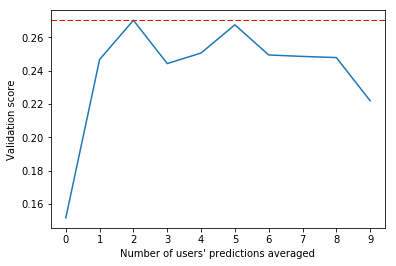

In [62]:
plt.plot(range(10), [y for x, y in rmse_analysis])
plt.xlabel("Number of users' predictions averaged")
plt.ylabel('Validation score')
plt.xticks([0, 1, 2, 3 ,4, 5, 6, 7, 8, 9])
plt.axhline(0.270350259451, linewidth=1, linestyle='dashed', color='r')

In [60]:
plt.axhline?

In [81]:
validation_df.sort_values('Validation', ascending=False)

,Item Weight,CF Weight,Avg Weight,Validation
0,0.0,1.0,1.0,0.305517
248,12.5,1.0,2.5,0.303608
39,0.0,3.5,3.0,0.302383
250,12.5,1.0,3.5,0.299383
57,2.5,1.5,1.5,0.299295
10,0.0,1.5,2.5,0.298611
344,17.5,1.0,1.5,0.298122
19,0.0,2.0,3.5,0.298008
37,0.0,3.5,2.0,0.297929
38,0.0,3.5,2.5,0.297301


In [66]:
validation_df = pd.read_csv('/Users/ericyatskowitz/galvanize_work/MeepleFinder/data/validation_df.csv')

In [79]:
validation_df.rename(columns={'RMSE':'Validation'}, inplace=True)

In [73]:
validation_df.drop([3, 13, 47], inplace=True)

In [ ]:
dict1 = np.load('data/us_ratings_data_1.npy').item()
dict2 = np.load('data/us_ratings_data_2.npy').item()
dict3 = np.load('data/us_ratings_data_3.npy').item()
dict4 = np.load('data/us_ratings_data_air_1.npy').item()
dict5 = np.load('data/us_ratings_data_air_2.npy').item()
dict6 = np.load('data/us_ratings_data_old_pro_1.npy').item()
dict7 = np.load('data/us_ratings_data_old_pro_2.npy').item()

In [ ]:
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

us_ratings_dict = merge_dicts(dict1, dict2, dict3, dict4, dict5, dict6, dict7)
us_ratings_dict_clean = dict((key, value) for key, value in us_ratings_dict.iteritems() if value != [])

In [ ]:
len(us_ratings_dict_clean)

In [ ]:
us_ratings = {}
for key in us_ratings_dict_clean.keys():
    count = 0
    for value in us_ratings_dict_clean[key]:
        if count == 0:
            us_ratings[key] = {value[0]: value[1]}
        else:
            us_ratings[key].update({value[0]: value[1]})
        count += 1

In [ ]:
us_ratings_df = pd.DataFrame(us_ratings)

In [ ]:
import pandas as pd
us_ratings_df = pd.read_csv('us_rating_df.csv')

In [ ]:
bg_ranking_data.read_csv('just_ranking_info.csv')

In [ ]:
geek_ratings = bg_ranking_data['Geek Rating']
num_ratings = bg_ranking_data['Num Ratings']

In [ ]:
us_ratings_df.rename(index=user_index, columns=board_game_index, inplace=True)

In [ ]:
us_als_data = us_ratings_df.stack().reset_index().rename(columns={'level_0':'user','level_1':'board_game', 0:'rating'})

In [ ]:
us_als_data.to_csv('als_ready_us_ratings_df.csv', encoding='utf-8')

In [ ]:
us_als_data.to_csv('us_als_data.csv', encoding='utf-8')

In [ ]:
board_games = dict(enumerate(us_ratings_df.columns))
board_game_index = dict((y,x) for x,y in board_games.iteritems())
users = dict(enumerate(us_ratings_df.index))
user_index = dict((y,x) for x,y in users.iteritems())

In [ ]:
board_game_index = np.load('board_game_dict.npy').item()
user_index = np.load('us_user_dict.npy').item()

In [ ]:
us_als_data

In [ ]:
for game in board_game_index.keys():
    us_als_data['board_game'].replace(to_replace=game, value=board_game_index[game], inplace=True)

In [ ]:
for user in user_index.keys():
    us_als_data['user'].replace(to_replace=user, value=user_index[user], inplace=True)